In [1]:
import os
from tqdm import tnrange, tqdm_notebook, tqdm
import itertools
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.utils import save_image, make_grid
from torch.autograd import Variable
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter

In [2]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (12, 8)

%matplotlib inline

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
torch.cuda.is_available()

True

In [6]:
device_ids = [0]

In [7]:
batch_size = 128
num_epochs = 100

z_dimension = 100
num_feature = (32, 4, 4) # 64 * 64

img_shape = (1, 32, 32)

In [8]:
img_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])

dataset = datasets.MNIST('/home/left5/datas/mnist', transform=img_transform) #, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [9]:
def to_categorical(y, num_columns):
    y_cat = np.zeros((y.shape[0], num_columns))
    y_cat[range(y.shape[0]), y] = 1.

#     return Variable(FloatTensor(y_cat))
    return torch.from_numpy(y_cat).float().cuda()

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            """Returns layers of each discriminator block"""
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1),
                     nn.LeakyReLU(0.2, inplace=True),
                     nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.conv_blocks = nn.Sequential(
            *discriminator_block(1, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = 32 // 2**4

        # Output layers
        self.adv_layer = nn.Sequential(nn.Linear(128*ds_size**2, 1))
        self.aux_layer = nn.Sequential(
            nn.Linear(128*ds_size**2, 10),
            nn.Softmax()
        )
        self.latent_layer = nn.Sequential(nn.Linear(128*ds_size**2, 2))

    def forward(self, img):
        out = self.conv_blocks(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        label = self.aux_layer(out)
        latent_code = self.latent_layer(out)

        return validity, label, latent_code

In [11]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        input_dim = 100 + 10 + 2

        self.init_size = 32 // 4 # Initial size before upsampling
        self.l1 = nn.Sequential(nn.Linear(input_dim, 128*self.init_size**2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 1, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, noise, labels, code):
        gen_input = torch.cat((noise, labels, code), -1)
        out = self.l1(gen_input)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [12]:
D = Discriminator().to(device)
G = Generator().to(device)

D = nn.DataParallel(D, device_ids=device_ids).to(device)
G = nn.DataParallel(G, device_ids=device_ids).to(device)

adversarial_loss = nn.MSELoss()
auxiliary_loss = torch.nn.CrossEntropyLoss()

D_optimezer = optim.Adam(D.parameters(), lr=2e-4, betas=(.5, .999))
G_optimezer = optim.Adam(G.parameters(), lr=2e-4, betas=(.5, .999))
I_optimezer = optim.Adam(itertools.chain(G.parameters(), D.parameters()), lr=2e-4, betas=(.5, .999))

In [13]:
lambda_cat = 1
lambda_con = 0.1

In [14]:
# condition = torch.from_numpy(np.arange(10)).cuda()
condition_labels = to_categorical(np.arange(10), num_columns=10)
code_x = np.linspace(-1, 1, 10)
code_y = np.linspace(-1, 1, 10)
code = torch.from_numpy(np.column_stack([code_x, code_y])).float().cuda()

NameError: name 'FloatTensor' is not defined

In [ ]:
writer = SummaryWriter('./log/cnn_info_cgan')

In [ ]:
img_path = "save_images/cnn_info_cgan"
if not os.path.exists(img_path): os.makedirs(img_path)

In [ ]:
total_count = len(dataloader)
for epoch in tqdm_notebook(range(num_epochs)):
    _step = epoch * total_count
    
    d_loss_total = .0
    g_loss_total = .0
    i_loss_total = .0
    for i, (imgs, labels) in enumerate(dataloader):
        
        real_imgs = imgs.cuda()
        real_labels = labels.cuda()
        
        real = torch.ones(imgs.size(0), 1).cuda()
        fake = torch.zeros(imgs.size(0), 1).cuda()
        
        z = torch.randn(imgs.size(0), z_dimension).cuda()
#         fake_labels = torch.from_numpy(np.random.randint(0, 10, imgs.size(0))).cuda()
        fake_labels = to_categorical(np.random.randint(0, 10, imgs.size(0)), 10).cuda()
        codes = torch.from_numpy(np.random.uniform(-1, 1, (imgs.size(0), 2))).float().cuda()
        
        ########## G ##########
        fake_imgs = G(z, fake_labels, codes)
        fake_out, _, _ = D(fake_imgs)
        g_loss = adversarial_loss(fake_out, real)
        
        G_optimezer.zero_grad()
        g_loss.backward()
        G_optimezer.step()
        #######################
        
        ########## D ##########
        real_out, _, _ = D(real_imgs)
        d_loss_real = adversarial_loss(real_out, real)
#         d_loss_real_label = auxiliary_loss(real_out_label, real_labels)
        real_scores = real_out
        
        fake_out, _, _ = D(fake_imgs.detach())
        d_loss_fake = adversarial_loss(fake_out, fake)
        fake_scores = fake_out
        
        d_loss = (d_loss_real + d_loss_fake) / 2 # + d_loss_real_label
        D_optimezer.zero_grad()
        d_loss.backward()
        D_optimezer.step()
        #######################
        
        
        sampled_labels = np.random.randint(0, 10, imgs.size(0))
        gt_labels = torch.from_numpy(sampled_labels).cuda()
        ########## I ##########
        z = torch.randn(imgs.size(0), z_dimension).cuda()
#         fake_labels = torch.from_numpy(np.random.randint(0, 10, imgs.size(0))).cuda()
        fake_labels = to_categorical(sampled_labels, num_columns=10)
        codes = torch.from_numpy(np.random.normal(-1, 1, (imgs.size(0), 2))).float().cuda()
        
        i_imgs = G(z, fake_labels, codes)
                                 
        _, fake_label, fake_code = D(i_imgs)
        
        i_loss = lambda_cat * auxiliary_loss(fake_label, gt_labels) + \
                 lambda_con * adversarial_loss(fake_code, codes)

        I_optimezer.zero_grad()
        i_loss.backward()
        I_optimezer.step()
        #######################
        
        d_loss_total += d_loss.item() * imgs.size(0)
        g_loss_total += g_loss.item() * imgs.size(0)
        i_loss_total += i_loss.item() * imgs.size(0)
        
        step = _step + i + 1
        
        if (i + 1) % 100 == 0:
            writer.add_scalar('Discriminator Real Loss', d_loss_real.item(), step)
            writer.add_scalar('Discriminator Fake Loss', d_loss_fake.item(), step)
            writer.add_scalar('Discriminator Loss', d_loss.item(), step)
            writer.add_scalar('Generator Loss', g_loss.item(), step)
            writer.add_scalar('Info Loss', i_loss.item(), step)
        
        if (i + 1) % 300 == 0:
            tqdm.write('Epoch [{}/{}], Step: {:6d}, d_loss: {:.6f}, g_loss: {:.6f}, i_loss: {:.6f}, real_scores: {:.6f}' \
', fake_scores: {:.6f}'.format(epoch+1, num_epochs, (i+1) * batch_size, d_loss, 
                                                    g_loss, i_loss, real_scores.mean(), fake_scores.mean()))
    
    setp = (epoch + 1) * total_count
    _d_loss_total = d_loss_total / (total_count * (epoch + 1))
    _g_loss_total = g_loss_total / (total_count * (epoch + 1))
    _i_loss_total = i_loss_total / (total_count * (epoch + 1))
    
    writer.add_scalar('Discriminator Total Loss', _d_loss_total, step)
    writer.add_scalar('Generator Total Loss', _g_loss_total, step)
    writer.add_scalar('Info Total Loss', _i_loss_total, step)
    
    tqdm.write("Finish Epoch [{}/{}], D Loss: {:.6f}, G Loss: {:.6f}, I Loss: {:.6f}".format(epoch+1, 
                                                                             num_epochs, 
                                                                             _d_loss_total,
                                                                             _g_loss_total,
                                                                             _i_loss_total, ))
    
    if epoch == 0:
        real_images = real_imgs.view(-1, 1, 32, 32).cpu().data
        save_image(real_images, os.path.join(img_path, 'real_images.png'))
        
    noise = torch.randn(10, z_dimension).cuda()
    condition_images = G(noise, condition_labels, code)
    
    writer.add_image('Generator Image', make_grid(fake_imgs.view(-1, 1, 32, 32).cpu().data, normalize=True, scale_each=True), step)
    writer.add_image('Condition Generator Image', make_grid(condition_images.view(-1, 1, 32, 32).cpu().data, normalize=True, scale_each=True), step)
    
    fake_images = fake_imgs.view(-1, 1, 32, 32).cpu().data
    save_image(fake_images, os.path.join(img_path, 'fake_images-{}.png'.format(epoch+1)))
    save_image(condition_images, os.path.join(img_path, 'condition_images-{}.png'.format(epoch+1)))

/usr/local/lib/python3.5/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/usr/local/lib/python3.5/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/usr/local/lib/python3.5/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.5/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.5/dist-packages/torch/nn/modules/contai

/usr/local/lib/python3.5/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.5/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.5/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.5/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/usr/local/lib/python3.5/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsa

/usr/local/lib/python3.5/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/usr/local/lib/python3.5/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/usr/local/lib/python3.5/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.5/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/usr/local/lib/python3.5/dist

/usr/local/lib/python3.5/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/usr/local/lib/python3.5/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/usr/local/lib/python3.5/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.5/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.5/dist-packages/torch/nn/modules/contai

/usr/local/lib/python3.5/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.5/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.5/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/usr/local/lib/python3.5/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/usr/local/lib/python3.5/dist-packages/torch/nn/modules/contai

/usr/local/lib/python3.5/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.5/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/usr/local/lib/python3.5/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/usr/local/lib/python3.5/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.5/dist-packages/torch/nn/modules/contai

/usr/local/lib/python3.5/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.5/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.5/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.5/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/usr/local/lib/python3.5/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsa

/usr/local/lib/python3.5/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/usr/local/lib/python3.5/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/usr/local/lib/python3.5/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.5/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/usr/local/lib/python3.5/dist

In [19]:
writer.close()

In [20]:
torch.save(D.state_dict(), './ser/info_gan_2_discriminator.pt')
torch.save(G.state_dict(), './ser/info_gan_2_generator.pt')

In [14]:
D.load_state_dict(torch.load('./ser/info_gan_2_discriminator.pt'))
G.load_state_dict(torch.load('./ser/info_gan_2_generator.pt'))

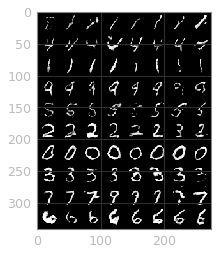

In [30]:
# words = np.arange(10)
# l = torch.from_numpy(words).cuda()


l = to_categorical(np.repeat(np.arange(10), 8), num_columns=10)
z = torch.randn(l.size(0), z_dimension).to(device)

code_x = np.repeat(np.linspace(-1, 1, 10), 8)
code_y = np.repeat(np.linspace(-1, 1, 10).reshape(1, 10), 8, axis=0).reshape(-1)
code = torch.from_numpy(np.column_stack([code_x, code_y])).float().cuda()

images = G(z, l, code)
# save_image(images, 'xx.png')
plt.imshow(Image.fromarray(make_grid(images).mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()))
plt.show()